In [1]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from math import sqrt
from shapleycomposition import ShapleyExplainer
from composition_stats import ilr, sbp_basis
from bifurc_tree import create_tree_from_sbp, init_graph, build_graph, sbp_from_aggloclustchildren
import plotly.graph_objects as go
from mahalanobis_matrix import mahalanobis_matrix
import matplotlib.pyplot as plt
import seaborn
import random

import plotly.io as pio
pio.renderers.default = "svg"

import seaborn as sns
sns.set_theme()

plt.rcParams['axes.grid'] = True
plt.rcParams['savefig.format'] = 'pdf'

np.random.seed(42)
random.seed(42)

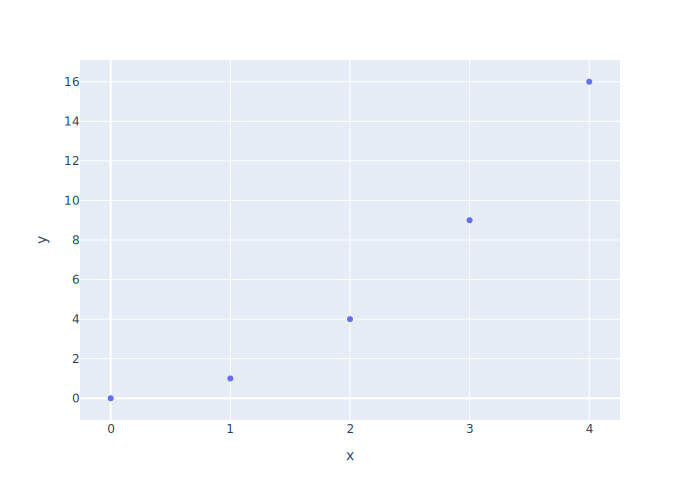

In [2]:
## Code to avoid having a "Loading [MathJax]/extensions/MathMenu.js" message
## in the following generated PDFS by plotly
import plotly.express as px

#garbage graph
fig = px.scatter(x=[0, 1, 2, 3, 4], y=[0, 1, 4, 9, 16])
fig.show()
fig.write_image("random.pdf")

In [3]:
import os

out_dir = os.path.join('figures', 'moreclasses')
os.makedirs(out_dir, exist_ok=True)

In [4]:
K = 10         #Index of the instance you want to test in the test set
N_class = 10   #Number of class, the dimension of the simplex is therefore N_class-1
N_feat  = 6    #In this example, since the number of feature of the digit dataset is quite large (64), we propose to reduce it with a PCA

#load the dataset, take a subset of N_class classes, scale it and split into a training and testing set
X, Y = datasets.load_digits(return_X_y=True)
subset_i = np.where(Y < N_class)
X = X[subset_i]
Y = Y[subset_i]
X = scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

#Reduce the number of feature to N_feat with a PCA
pca = PCA(n_components=N_feat)
X_train = pca.fit_transform(X_train)
X_test  = pca.transform(X_test)


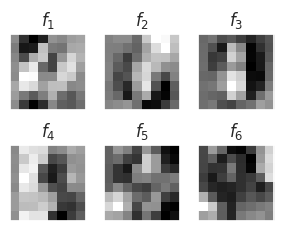

In [5]:
fig, ax_list = plt.subplots(nrows=2, ncols=int(N_feat/2), figsize=(3, 2.5))
for i, (c, ax) in enumerate(zip(pca.components_, ax_list.flatten())):
    ax.set_title(f'$f_{i+1}$')
    ax.imshow(c.reshape([8,8]), cmap='grey')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
fig.tight_layout()
fig.savefig(os.path.join(out_dir, 'ex_gt4_pca_components.pdf'))

In [6]:
#train an SVM classifier
svc_linear = svm.SVC(kernel='rbf', probability=True)
svc_linear.fit(X_train, Y_train)

SVC(probability=True)

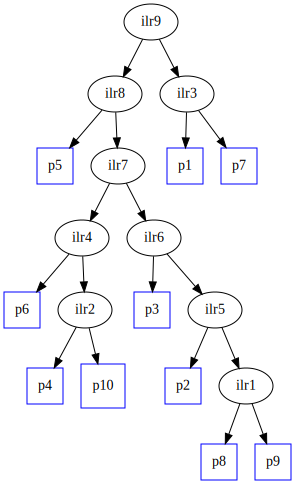

In [7]:
#Choose a sequential binary partition matrix and plot the corresponding bifurcation tree
# sbpmatrix = np.array([[1,1,-1,-1,1,1,1],[1,-1,0,0,-1,-1,-1],[0,1,0,0,-1,-1,-1],[0,0,0,0,1,-1,-1],[0,0,0,0,0,1,-1],[0,0,1,-1,0,0,0]])
#sbpmatrix = np.array([[1,-1,1,-1,1,-1,1],[1,0,1,0,-1,0,-1],[0,0,0,0,1,0,-1],[1,0,-1,0,1,0,0],[0,1,0,1,0,-1,0],[0,1,0,-1,0,0,0]])

#Get a sequential binary parition from the agglomeration of classes from a distance matrix between classes. Distance matrix is here made of the mahalanobis distance between a pair of classes in the ILR space output by the classifier (assuming normal distribution with same covariance matrix between a pair of classes).
M = mahalanobis_matrix(svc_linear.predict_proba, X_test, Y_test)
sbpmatrix = sbp_from_aggloclustchildren(AgglomerativeClustering(metric='precomputed', linkage='average').fit(M).children_)

#basis = np.flip(sbp_basis(sbpmatrix), axis=0)
basis = sbp_basis(sbpmatrix)
root = create_tree_from_sbp(sbpmatrix, N_class)

##Visualise the tree using graphviz
graph = init_graph()
build_graph(root, graph)
#graph.render('tree.pdf', view=True)
graph       #plot the bifurcation tree


In [8]:
# Explain all the predictions in the test set
explainer = ShapleyExplainer(svc_linear.predict_proba, X_train, N_class, sbpmatrix=sbpmatrix,
                            names_classes=[str(i) for i in range(N_class)])
(shapley, base) = explainer.explain_instance(np.array(X_test[K]))


print("True label of the tested instance: ", end="")
print(Y_test[K])

#get the model prediction for the Kth instance of the test partition
pred = svc_linear.predict_proba(X_test[K].reshape(1,-1))
print("Prediction on the simplex: ",end="")
print(pred)
ilr_pred = ilr(pred, basis=basis)
print("Prediction in the ILR space: ",end="")
print(ilr_pred)

#The sum of the base distribution and the shapley composition in the ILR space is equal to the predicted probability distribution
sum_shap_base = np.array(shapley).sum(axis=0)+base
print("Sum of the shapley composition and the base distribution in the ILR space: ", end="")
print(sum_shap_base)

True label of the tested instance: 2
Prediction on the simplex: [[0.00185343 0.00279981 0.96453206 0.00625118 0.00832076 0.00284955
  0.00176099 0.00339704 0.00279416 0.00544102]]
Prediction in the ILR space: [ 0.13814889  0.09814952  0.03617974 -0.58478042 -0.078112    5.00416768
 -1.32668649  0.01413141  1.91517403]
Sum of the shapley composition and the base distribution in the ILR space: [ 0.13811192  0.09843844  0.03582945 -0.58475028 -0.07806866  5.0039832
 -1.32667603  0.01447693  1.91519731]


In [9]:
#SUMMARIZE WITH NORM, COSINE AND INNER PRODUCTS

(norm_shapley, proj_shap_class, cos_shap_shap) = explainer.summarize()

List of the features sorted by their Shapley strength (norm of their Shapley composition):
	 feature n.1: 3.9880384
	 feature n.3: 2.2320421
	 feature n.4: 1.2716365
	 feature n.2: 1.121771
	 feature n.6: 1.0568648
	 feature n.5: 0.5680661

Projection of the Shapley compositions on the class vectors:
		feature n.1	feature n.2	feature n.3	feature n.4	feature n.5	feature n.6	
0:        	1.9498245	-0.4042659	-0.2332148	0.1160415	-0.0799254	0.0780634	
1:        	-0.5704481	0.4047476	-0.1076590	-0.1100012	-0.0508854	0.5902758	
2:        	0.1904490	0.2078170	-0.3483382	0.5356773	-0.2689574	0.0640153	
3:        	-0.2443604	0.1178132	0.6185611	0.0766386	-0.3517053	0.4273582	
4:        	1.7647920	-0.0390937	0.2125734	-1.1083479	0.3167167	-0.1278541	
5:        	0.6662986	-0.1263560	-0.6886888	0.2197700	0.1590195	-0.1896036	
6:        	-2.5037958	-0.7000005	-0.9449654	-0.1423038	-0.0107788	-0.4095221	
7:        	0.3315747	-0.0482310	1.8601434	0.3146938	0.1078686	-0.5721455	
8:        	0.2698979	-

In [10]:
import pandas as pd
from IPython.display import display, HTML

df_cos = pd.DataFrame(cos_shap_shap, index=[f"feature n.{i+1}" for i in range(N_feat)],
                     columns=[f"feature n.{i+1}" for i in range(N_feat)]).round(2)

df_cos.round(2).astype(str).to_latex(os.path.join(out_dir, 'cosine.tex'))
display(HTML(df_cos.to_html()))

df_proj = pd.DataFrame(proj_shap_class, index=[str(i) for i in range(N_class)],
                     columns=[f"feature n.{i+1}" for i in range(N_feat)]).round(2)

df_proj.round(2).astype(str).to_latex(os.path.join(out_dir, 'projections.tex'))
display(HTML(df_proj.to_html()))

df_norm = pd.DataFrame(norm_shapley, index=[f"feature n.{i+1}" for i in range(N_feat)], columns=['norm']).round(2)

df_norm.round(2).astype(str).to_latex(os.path.join(out_dir, 'norm.tex'))
display(HTML(df_norm.to_html()))

,feature n.1,feature n.2,feature n.3,feature n.4,feature n.5,feature n.6
feature n.1,1.00,-0.15,0.24,-0.26,0.21,0.14
feature n.2,-0.15,1.00,0.25,0.20,-0.10,0.33
feature n.3,0.24,0.25,1.00,0.06,0.02,-0.19
feature n.4,-0.26,0.20,0.06,1.00,-0.56,-0.07
feature n.5,0.21,-0.10,0.02,-0.56,1.00,-0.47
feature n.6,0.14,0.33,-0.19,-0.07,-0.47,1.00


,feature n.1,feature n.2,feature n.3,feature n.4,feature n.5,feature n.6
0,1.95,-0.40,-0.23,0.12,-0.08,0.08
1,-0.57,0.40,-0.11,-0.11,-0.05,0.59
2,0.19,0.21,-0.35,0.54,-0.27,0.06
3,-0.24,0.12,0.62,0.08,-0.35,0.43
4,1.76,-0.04,0.21,-1.11,0.32,-0.13
5,0.67,-0.13,-0.69,0.22,0.16,-0.19
6,-2.50,-0.70,-0.94,-0.14,-0.01,-0.41
7,0.33,-0.05,1.86,0.31,0.11,-0.57
8,0.27,-0.11,-0.30,-0.15,0.10,0.34
9,-1.85,0.70,-0.07,0.25,0.08,-0.20


,norm
feature n.1,3.99
feature n.2,1.12
feature n.3,2.23
feature n.4,1.27
feature n.5,0.57
feature n.6,1.06


In [11]:
import pandas as pd

df_cos = pd.DataFrame(cos_shap_shap, index=[f"feature n.{i+1}" for i in range(N_feat)],
                     columns=[f"feature n.{i+1}" for i in range(N_feat)])

df_cos.to_latex(os.path.join(out_dir, 'cosine.tex'))

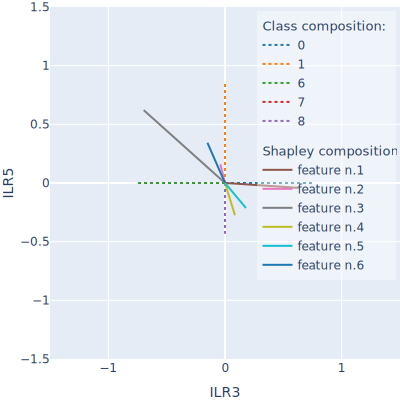

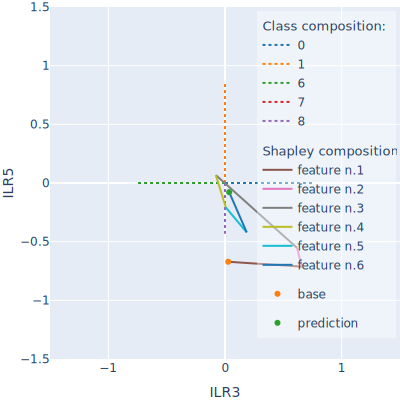

In [12]:
#PLOT the a ILR subspace (corresponding to the chosen ILR components listed in balances).
#plot range [-lim, lim]
#If shapley_sum is True, the sum of the shapley vectors are summed from the base distribution to the prediction

fig = explainer.plot_ilr_space(balances=[3, 5], lim=1.5, figsize=400)
fig.write_image(os.path.join(out_dir, 'ex_gt4_ilrplot.pdf'))

fig = explainer.plot_ilr_space(balances=[3, 5], shapley_sum=True, lim=1.5, figsize=400)
fig.write_image(os.path.join(out_dir, 'ex_gt4_ilrplotsum.pdf'))

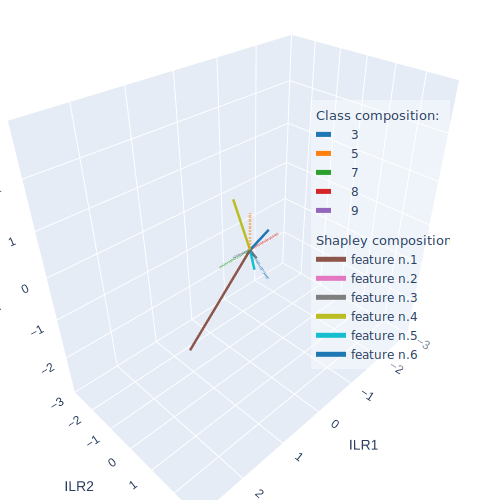

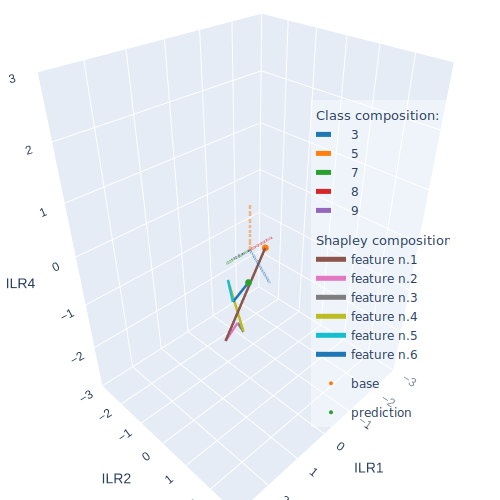

In [13]:
#PLOT the a ILR subspace (corresponding to the chosen ILR components listed in balances).
#plot range [-lim, lim]
#If shapley_sum is True, the sum of the shapley vectors are summed from the base distribution to the prediction

fig = explainer.plot_ilr_space(balances=[1, 2, 4], lim=3)
fig = explainer.plot_ilr_space(balances=[1, 2, 4], shapley_sum=True, lim=3)


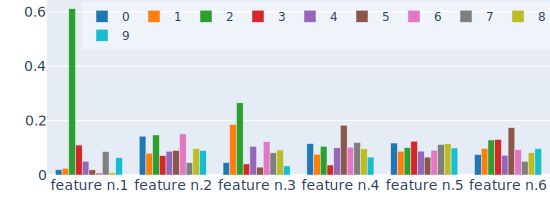

In [14]:
#Plot the Shapley compositions as histograms

fig = explainer.shapley_histogram(figheight=220, figwidth=550)
fig.write_image(os.path.join(out_dir, 'ex_gt4_histo.pdf'))

[0 2 3 1 5 4]
Number of classes = 10
['Base' '$\\oplus\\phi_1$' '$\\oplus\\phi_3$' '$\\oplus\\phi_4$'
 '$\\oplus\\phi_2$' '$\\oplus\\phi_6$' '$\\oplus\\phi_5$']
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[[0.05477999 0.00964677 0.00234557 0.00262604 0.00266487 0.00158088
  0.00185331]
 [0.04437318 0.00998523 0.00986082 0.00731368 0.00416919 0.00321192
  0.00280047]
 [0.11225031 0.62490815 0.88356937 0.90550198 0.94729782 0.96339325
  0.96452288]
 [0.12536976 0.12571154 0.02719138 0.00968869 0.00489521 0.00505188
  0.00625337]
 [0.10655056 0.04899615 0.02749244 0.02672838 0.01657289 0.00950414
  0.00832511]
 [0.10476222 0.01801692 0.00278295 0.00493228 0.00316499 0.0043486
  0.00285007]
 [0.0526881  0.00380294 0.00247766 0.00245838 0.00263898 0.00193697
  0.00176174]
 [0.06092385 0.04769088 0.02074024 0.02398715 0.00766633 0.00304355
  0.00339758]
 [0.16726862 0.01198644 0.00587217 0.00548065 0.00377364 0.00243551
  0.00279475]
 [0.17103341 0.09925499 0.0176674  0.01128277 0.007

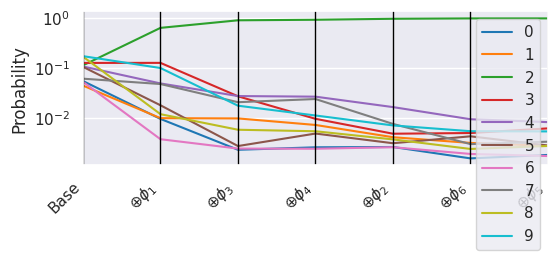

In [15]:
from utils import plot_composite_shapley_feature_contributions

from composition_stats import ilr, sbp_basis
from shapleycomposition import ilr_inv

space, b = 'Prob', basis
parname, parallel = 'parallel', True

fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot()
ax.set_yscale('log')
fig, ax = plot_composite_shapley_feature_contributions(np.array(shapley), base=base, cummulative=True,
                                                       sort_by_norm=True, basis=b,
                                                       parallel=parallel,
                                                       feature_names=[f"$\oplus\phi_{i+1}$" for i in range(N_feat)],
                                                       target_names=[str(i) for i in range(N_class)],
                                                       fig=fig, ax=ax,
                                                       #title=f"Composite Shapley {space} cumsum sorted"
                                                      )
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
L=ax.legend(loc='upper center', bbox_to_anchor=(0.7, 0.9),
            fancybox=True, shadow=True, ncols=5, handlelength=0.5)


fig.savefig(os.path.join(out_dir, f'comp_shap_{space}_cum_sorted_{parname}'), dpi=300, bbox_inches='tight')